In [1]:
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from tqdm import tqdm
from mendeleev.fetch import fetch_table
from seaborn_fig2grid import SeabornFig2Grid
import matplotlib.gridspec as gridspec
import pickle
import matplotlib

sns.set_style('whitegrid')
%matplotlib inline

sys.path.append(str(Path().resolve().parent))
Path("plots/gfn_samples").mkdir(parents=True, exist_ok=True)

sns.set_palette(sns.color_palette("colorblind", 4))

output_path = Path("plots/gfn_samples_v2")
output_path.mkdir(parents=True, exist_ok=True)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [2]:
def denorm_l(l, min_l=0.9, max_l=100):
    return l * (max_l - min_l) + min_l

def denorm_a(a, min_a=50, max_a=150):
    return a * (max_a - min_a) + min_a

def make_row(d, sg_idx, nz, els, denorm=False):
    s = {}
    for k in range(nz):
        s[els[k]] = d[k + 1]
    s["sg"] = d[sg_idx]
    s["a"] = d[sg_idx + 1]
    s["b"] = d[sg_idx + 2]
    s["c"] = d[sg_idx + 3]
    s["alpha"] = d[sg_idx + 4]
    s["beta"] = d[sg_idx + 5]
    s["gamma"] = d[sg_idx + 6]
    if denorm:
        for k in ["a", "b", "c"]:
            s[k] = denorm_l(s[k])
        for k in ["alpha", "beta", "gamma"]:
            s[k] = denorm_a(s[k])
    return s

In [3]:
data_path = "../../gflownet/data/crystals/matbench_val_12_SGinter_states_energy.pkl"
samples_path = "./plots/gfn_samples_v2/samples_all.pkl"
train_path = "/network/scratch/s/schmidtv/crystals-proxys/data/materials_dataset_v3/data/matbench_mp_e_form/train_data.csv"

with open(data_path, "rb") as f:
    data = pickle.load(f)
with open(samples_path, "rb") as f:
    samples = pickle.load(f)
traindf = pd.read_csv(train_path)


In [4]:
zs = np.array([1, 3, 6, 7, 8, 9, 12, 14, 15, 16, 17, 26])
table = fetch_table("elements")["symbol"]
els = table.iloc[zs-1].values
nz = len(zs)
sg_idx = nz + 3

valdf = []
for i, d in enumerate(data["x"]):
    row = make_row(d, sg_idx, nz, els, denorm=False)
    row["energy"] = data["energy"][i]
    valdf.append(row)
valdf = pd.DataFrame(valdf)

sdf = []
for i, d in enumerate(samples["Crystal-GFlownet"]["x"]):
    row = make_row(d, sg_idx, nz, els, denorm=True)
    row["energy"] = samples["Crystal-GFlownet"]["energy"][i]
    sdf.append(row)
sdf = pd.DataFrame(sdf)

In [5]:
h_idx = traindf.columns.to_list().index("H")
e_idx = traindf.columns.to_list().index("Eform")

non_allowed_els = [c for c in traindf.columns[h_idx:e_idx] if c not in els]
keep_comp = traindf[non_allowed_els].sum(axis=1) == 0
traindf = traindf.iloc[keep_comp.values]


In [6]:
assert len(traindf) == 2987

In [7]:
allowed_sgs = set([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 25, 26, 29, 30, 31, 33, 36, 38, 40, 41, 43, 44, 46, 47, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 69, 70, 71, 72, 74, 82, 84, 85, 86, 87, 88, 92, 99, 102, 107, 113, 114, 121, 122, 123, 126, 129, 131, 136, 137, 138, 139, 140, 141, 146, 147, 148, 150, 155, 156, 160, 161, 162, 163, 164, 166, 167, 176, 181, 185, 186, 187, 189, 192, 194, 198, 199, 205, 206, 216, 217, 220, 221, 224, 225, 227, 229, 230])

traindf = traindf[traindf["Space Group"].isin(allowed_sgs)]
traindf["sg"] = traindf["Space Group"]
traindf["energy"] = traindf["Eform"]
traindf = traindf[sdf.columns]

In [8]:
print(f"Number of samples: {len(sdf)}")
print(f"Number of validation samples: {len(valdf)}")
print(f"Number of training samples: {len(traindf)}")

Number of samples: 10000
Number of validation samples: 1118
Number of training samples: 2861


In [9]:
sdf["source"] = "Crystal-GFlownet"
valdf["source"] = "MatBench Val"
traindf["source"] = "MatBench Train"
df = pd.concat([sdf, valdf, traindf])

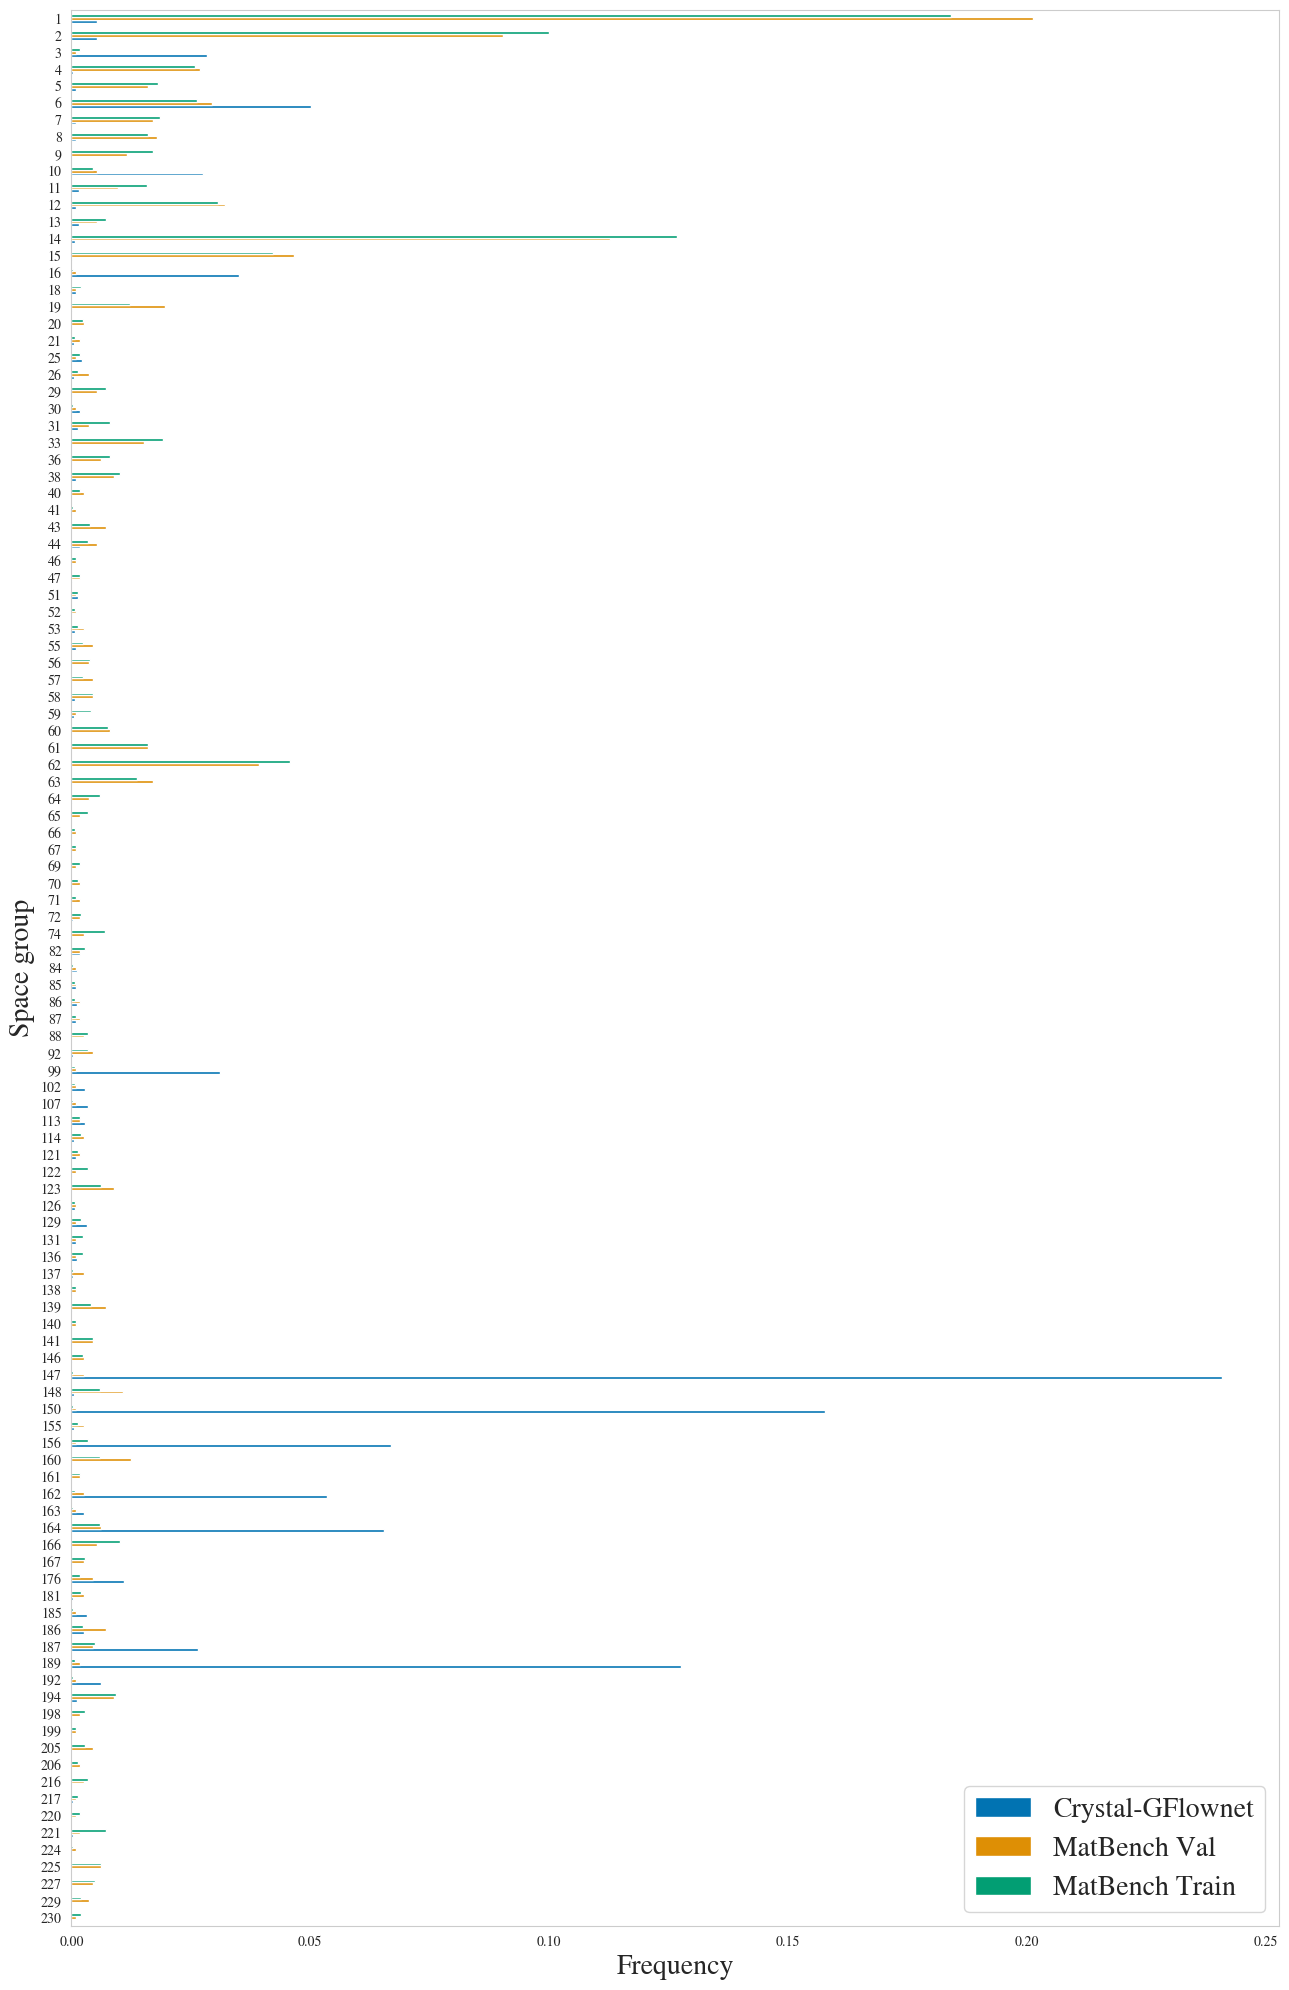

In [10]:
# plot the bar plot of the space group distribution
# in the data versus the samples
# counts should be normalized by the total number of elements per data source

sdf_sg_counts = sdf["sg"].value_counts().sort_index()
sdf_sg_counts = sdf_sg_counts / sdf_sg_counts.sum()
valdf_sg_counts = valdf["sg"].value_counts().sort_index()
valdf_sg_counts = valdf_sg_counts / valdf_sg_counts.sum()
traindf_sg_counts = traindf["sg"].value_counts().sort_index()
traindf_sg_counts = traindf_sg_counts / traindf_sg_counts.sum()

sg_counts = pd.concat([sdf_sg_counts, valdf_sg_counts, traindf_sg_counts], axis=1).sort_index(ascending=False)
sg_counts.columns = ["Crystal-GFlownet", "MatBench Val", "MatBench Train"]
sg_counts = sg_counts.fillna(0)

fig, ax = plt.subplots(figsize=(13, 20))
sg_counts.plot.barh(ax=ax)
ax.set_xlabel("Frequency", fontsize=20)
ax.set_ylabel("Space group", fontsize=20)
fig.tight_layout()
ax.grid(False)
ax.legend(fontsize=20, loc="lower right")
fig.savefig(output_path / "sg_counts.pdf")


In [11]:
sg_counts

,Crystal-GFlownet,MatBench Val,MatBench Train
sg,,,
230,0.0000,0.000894,0.002097
229,0.0000,0.003578,0.002097
227,0.0000,0.004472,0.004893
225,0.0000,0.006261,0.006292
224,0.0000,0.000894,0.000350
...,...,...,...
5,0.0010,0.016100,0.018175
4,0.0004,0.026834,0.025865
3,0.0283,0.000894,0.001748


In [12]:
print(sdf_sg_counts.index.to_list())
print(valdf_sg_counts.index.to_list())
print(traindf_sg_counts.index.to_list())

[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 18, 19, 21, 25, 26, 29, 30, 31, 36, 38, 41, 44, 47, 51, 53, 55, 56, 58, 59, 62, 64, 72, 82, 84, 85, 86, 87, 92, 99, 102, 107, 113, 114, 121, 122, 126, 129, 131, 136, 137, 138, 139, 140, 146, 147, 148, 150, 155, 156, 160, 162, 163, 164, 166, 176, 181, 185, 186, 187, 189, 192, 194, 198, 217, 221]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 25, 26, 29, 30, 31, 33, 36, 38, 40, 41, 43, 44, 46, 47, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 69, 70, 71, 72, 74, 82, 84, 85, 86, 87, 88, 92, 99, 102, 107, 113, 114, 121, 122, 123, 126, 129, 131, 136, 137, 138, 139, 140, 141, 146, 147, 148, 150, 155, 156, 160, 161, 162, 163, 164, 166, 167, 176, 181, 185, 186, 187, 189, 192, 194, 198, 199, 205, 206, 216, 217, 220, 221, 224, 225, 227, 229, 230]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 25, 26, 29, 30, 31, 33, 36, 38, 40, 41, 43, 44, 46, 47, 51, 52, 53, 55, 56, 57, 58, 5

In [13]:
print(sg_counts.index.to_list())
sg_counts

[230, 229, 227, 225, 224, 221, 220, 217, 216, 206, 205, 199, 198, 194, 192, 189, 187, 186, 185, 181, 176, 167, 166, 164, 163, 162, 161, 160, 156, 155, 150, 148, 147, 146, 141, 140, 139, 138, 137, 136, 131, 129, 126, 123, 122, 121, 114, 113, 107, 102, 99, 92, 88, 87, 86, 85, 84, 82, 74, 72, 71, 70, 69, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 53, 52, 51, 47, 46, 44, 43, 41, 40, 38, 36, 33, 31, 30, 29, 26, 25, 21, 20, 19, 18, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]


,Crystal-GFlownet,MatBench Val,MatBench Train
sg,,,
230,0.0000,0.000894,0.002097
229,0.0000,0.003578,0.002097
227,0.0000,0.004472,0.004893
225,0.0000,0.006261,0.006292
224,0.0000,0.000894,0.000350
...,...,...,...
5,0.0010,0.016100,0.018175
4,0.0004,0.026834,0.025865
3,0.0283,0.000894,0.001748


In [14]:
__a = pd.concat([sdf_sg_counts, valdf_sg_counts, traindf_sg_counts], axis=1, sort=True, join="outer", ignore_index=True).fillna(0)
print(__a.index.to_list())
__a

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 25, 26, 29, 30, 31, 33, 36, 38, 40, 41, 43, 44, 46, 47, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 69, 70, 71, 72, 74, 82, 84, 85, 86, 87, 88, 92, 99, 102, 107, 113, 114, 121, 122, 123, 126, 129, 131, 136, 137, 138, 139, 140, 141, 146, 147, 148, 150, 155, 156, 160, 161, 162, 163, 164, 166, 167, 176, 181, 185, 186, 187, 189, 192, 194, 198, 199, 205, 206, 216, 217, 220, 221, 224, 225, 227, 229, 230]


,0,1,2
sg,,,
1,0.0054,0.201252,0.184201
2,0.0054,0.090340,0.099965
3,0.0283,0.000894,0.001748
4,0.0004,0.026834,0.025865
5,0.0010,0.016100,0.018175
...,...,...,...
224,0.0000,0.000894,0.000350
225,0.0000,0.006261,0.006292
227,0.0000,0.004472,0.004893


In [15]:
empty_train_sg = set(allowed_sgs) - set(traindf["sg"].unique())
empty_val_sg = set(allowed_sgs) - set(valdf["sg"].unique())
empty_sdf_sg = set(allowed_sgs) - set(sdf["sg"].unique())

print(f"Empty space groups in training data: {empty_train_sg} (n={len(empty_train_sg)})")
print(f"Empty space groups in validation data: {empty_val_sg} (n={len(empty_val_sg)})")
print(f"Empty space groups in samples: {empty_sdf_sg} (n={len(empty_sdf_sg)})")

Empty space groups in training data: set() (n=0)
Empty space groups in validation data: set() (n=0)
Empty space groups in samples: {9, 141, 20, 33, 161, 167, 40, 43, 46, 52, 57, 60, 61, 63, 65, 66, 67, 69, 70, 71, 199, 74, 205, 206, 88, 216, 220, 224, 225, 227, 229, 230, 123} (n=33)


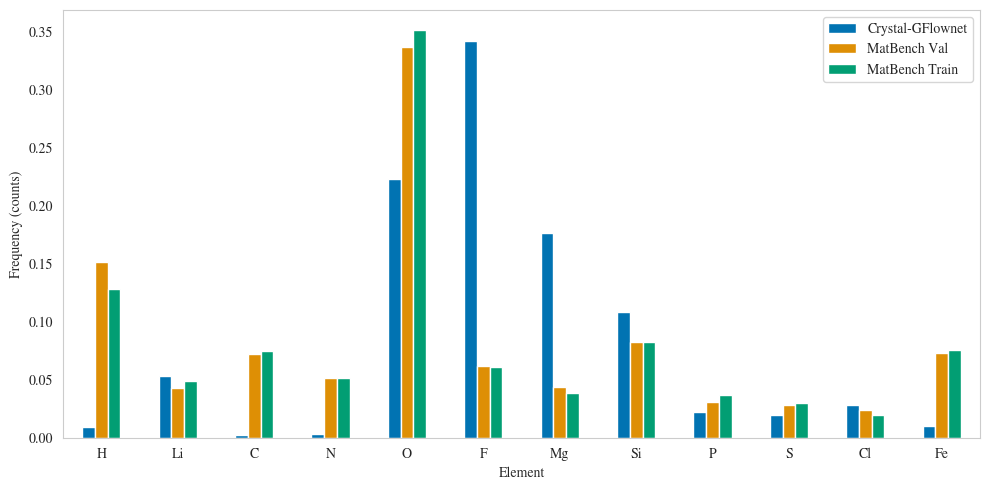

In [22]:
# plot the bar plot of the element distribution
# in the data versus the samples
# counts should be normalized by the total number of elements per data source

sdf_el_counts = sdf[els].sum(axis=0)
sdf_el_counts = sdf_el_counts / sdf_el_counts.sum()
valdf_el_counts = valdf[els].sum(axis=0)
valdf_el_counts = valdf_el_counts / valdf_el_counts.sum()
traindf_el_counts = traindf[els].sum(axis=0)
traindf_el_counts = traindf_el_counts / traindf_el_counts.sum()

el_counts = pd.concat([sdf_el_counts, valdf_el_counts, traindf_el_counts], axis=1)
el_counts.columns = ["Crystal-GFlownet", "MatBench Val", "MatBench Train"]
el_counts = el_counts.fillna(0)

fig, ax = plt.subplots(figsize=(10, 5))
el_counts.plot.bar(ax=ax)
ax.set_ylabel("Frequency (counts)")
ax.set_xlabel("Element")
ax.set_xticklabels(el_counts.index, rotation=360)
fig.tight_layout()
ax.grid(False)
fig.savefig(output_path / "el_counts_total.pdf")

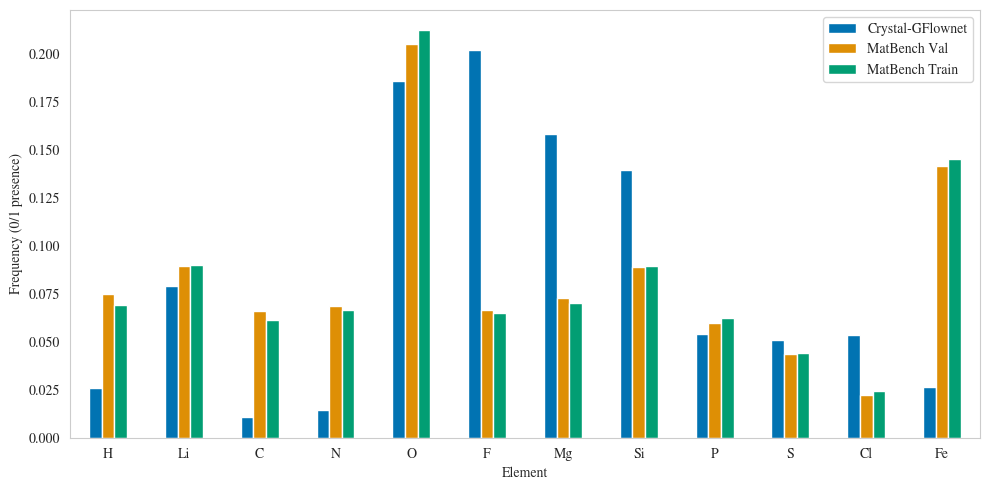

In [21]:
# plot the bar plot of the element distribution
# in the data versus the samples
# counts should be normalized by the total number of elements per data source

sdf_el_counts = (sdf[els] > 0).sum(axis=0)
sdf_el_counts = sdf_el_counts / sdf_el_counts.sum()
valdf_el_counts = (valdf[els] > 0).sum(axis=0)
valdf_el_counts = valdf_el_counts / valdf_el_counts.sum()
traindf_el_counts = (traindf[els] > 0).sum(axis=0)
traindf_el_counts = traindf_el_counts / traindf_el_counts.sum()

el_counts = pd.concat([sdf_el_counts, valdf_el_counts, traindf_el_counts], axis=1)
el_counts.columns = ["Crystal-GFlownet", "MatBench Val", "MatBench Train"]
el_counts = el_counts.fillna(0)

fig, ax = plt.subplots(figsize=(10, 5))
el_counts.plot.bar(ax=ax)
ax.set_ylabel("Frequency (0/1 presence)")
ax.set_xlabel("Element")
ax.set_xticklabels(el_counts.index, rotation=360)
fig.tight_layout()
ax.grid(False)
fig.savefig(output_path / "el_counts_binary.pdf")

In [19]:
sdf[els]

,H,Li,C,N,O,F,Mg,Si,P,S,Cl,Fe
0,0,6,0,0,0,14,5,0,0,0,0,0
1,0,0,0,0,16,14,16,0,0,0,0,2
2,0,5,0,0,6,15,0,5,0,0,0,0
3,0,8,0,0,0,16,12,0,0,0,4,0
4,0,0,0,0,6,14,0,8,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,0,0,0,9,15,15,0,4,0,0,0
9996,0,9,0,0,13,11,3,0,1,0,0,0
9997,0,7,0,0,8,9,0,4,1,0,0,0
9998,0,4,0,0,10,15,11,9,0,0,0,0


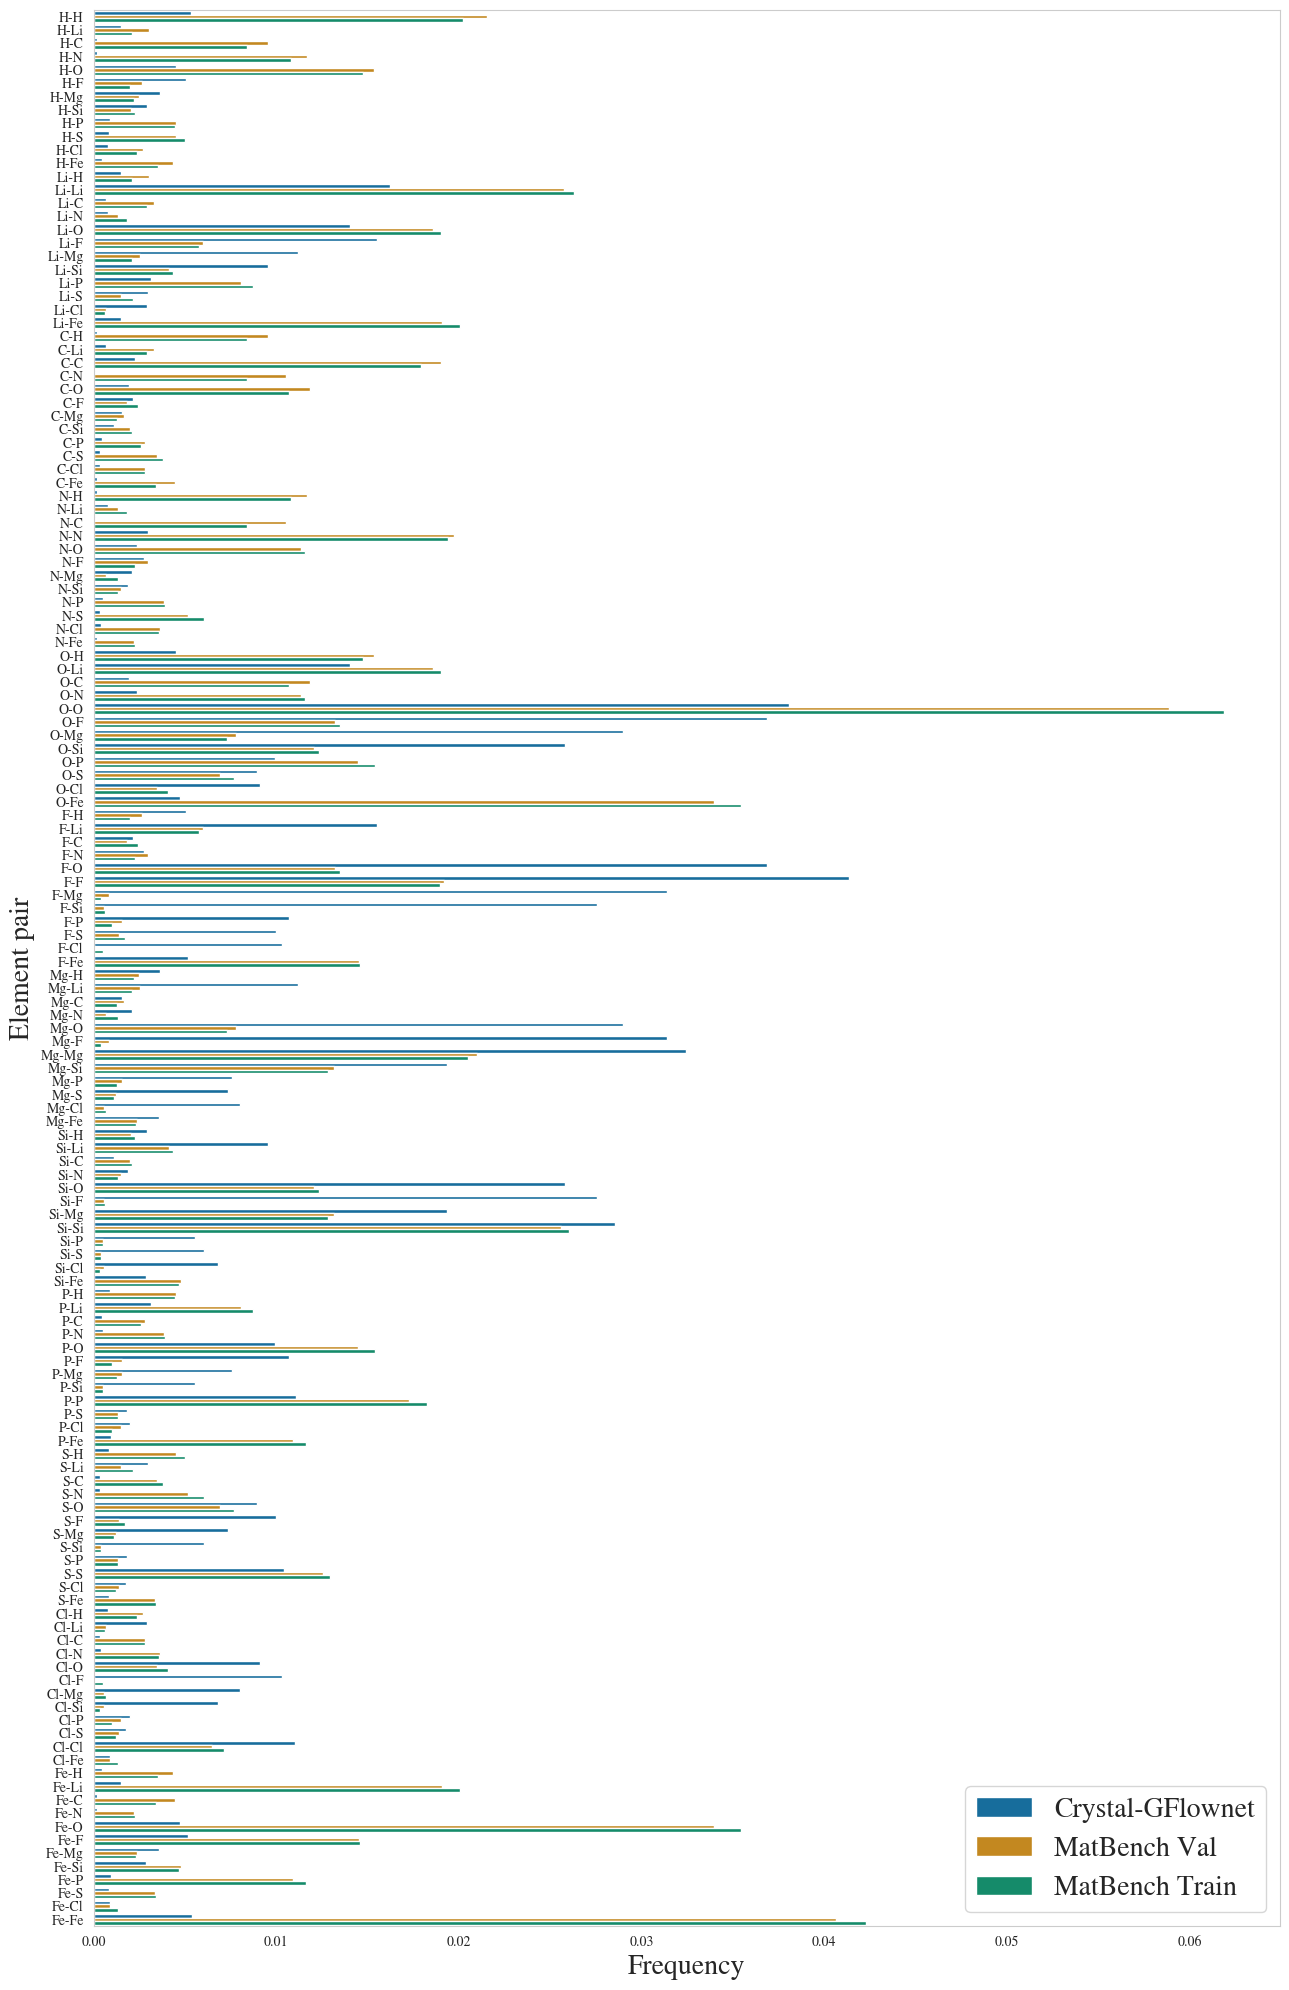

In [19]:
# plot the bar plot of the binarized element co-occurrences
# in the data versus the samples
# counts should be normalized by the total number of elements per data source

cooc_bin_counts_normed = []
for tmp_df in [sdf, valdf, traindf]:
    bin_df = (tmp_df[els] > 0).astype(int)
    cooc_df = bin_df.T.dot(bin_df)
    cooc_df = cooc_df / cooc_df.sum().sum()
    cooc_bin_counts_normed.append(cooc_df)

cooc_df = []
for t, tmp_df in enumerate(cooc_bin_counts_normed):
    for i in tmp_df.index:
        for j in tmp_df.columns:
            cooc_df.append(
                {
                    "pair": f"{i}-{j}",
                    "frequency": tmp_df.loc[i, j],
                    "source": ["Crystal-GFlownet", "MatBench Val", "MatBench Train"][t],
                }
            )
cooc_df = pd.DataFrame(cooc_df)

fig, ax = plt.subplots(figsize=(13, 20))
# horizontal bar plot
sns.barplot(data=cooc_df, y="pair", x="frequency", hue="source", ax=ax)
ax.set_xlabel("Frequency", fontdict={"size": 20})
ax.set_ylabel("Element pair", fontdict={"size": 20})
ax.set_yticklabels(cooc_df["pair"].unique())
fig.tight_layout()
ax.grid(False)
ax.legend(fontsize=20, loc="lower right")
fig.savefig(output_path / "el_cooc_counts.pdf")

/tmp/ipykernel_41730/432069784.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(denorm_yticks)
/tmp/ipykernel_41730/432069784.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(denorm_yticks)
/tmp/ipykernel_41730/432069784.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(denorm_yticks)
/tmp/ipykernel_41730/432069784.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(denorm_yticks)
/tmp/ipykernel_41730/432069784.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(denorm_yticks)
/tmp/ipykernel_41730/432069784.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(denorm_yticks)


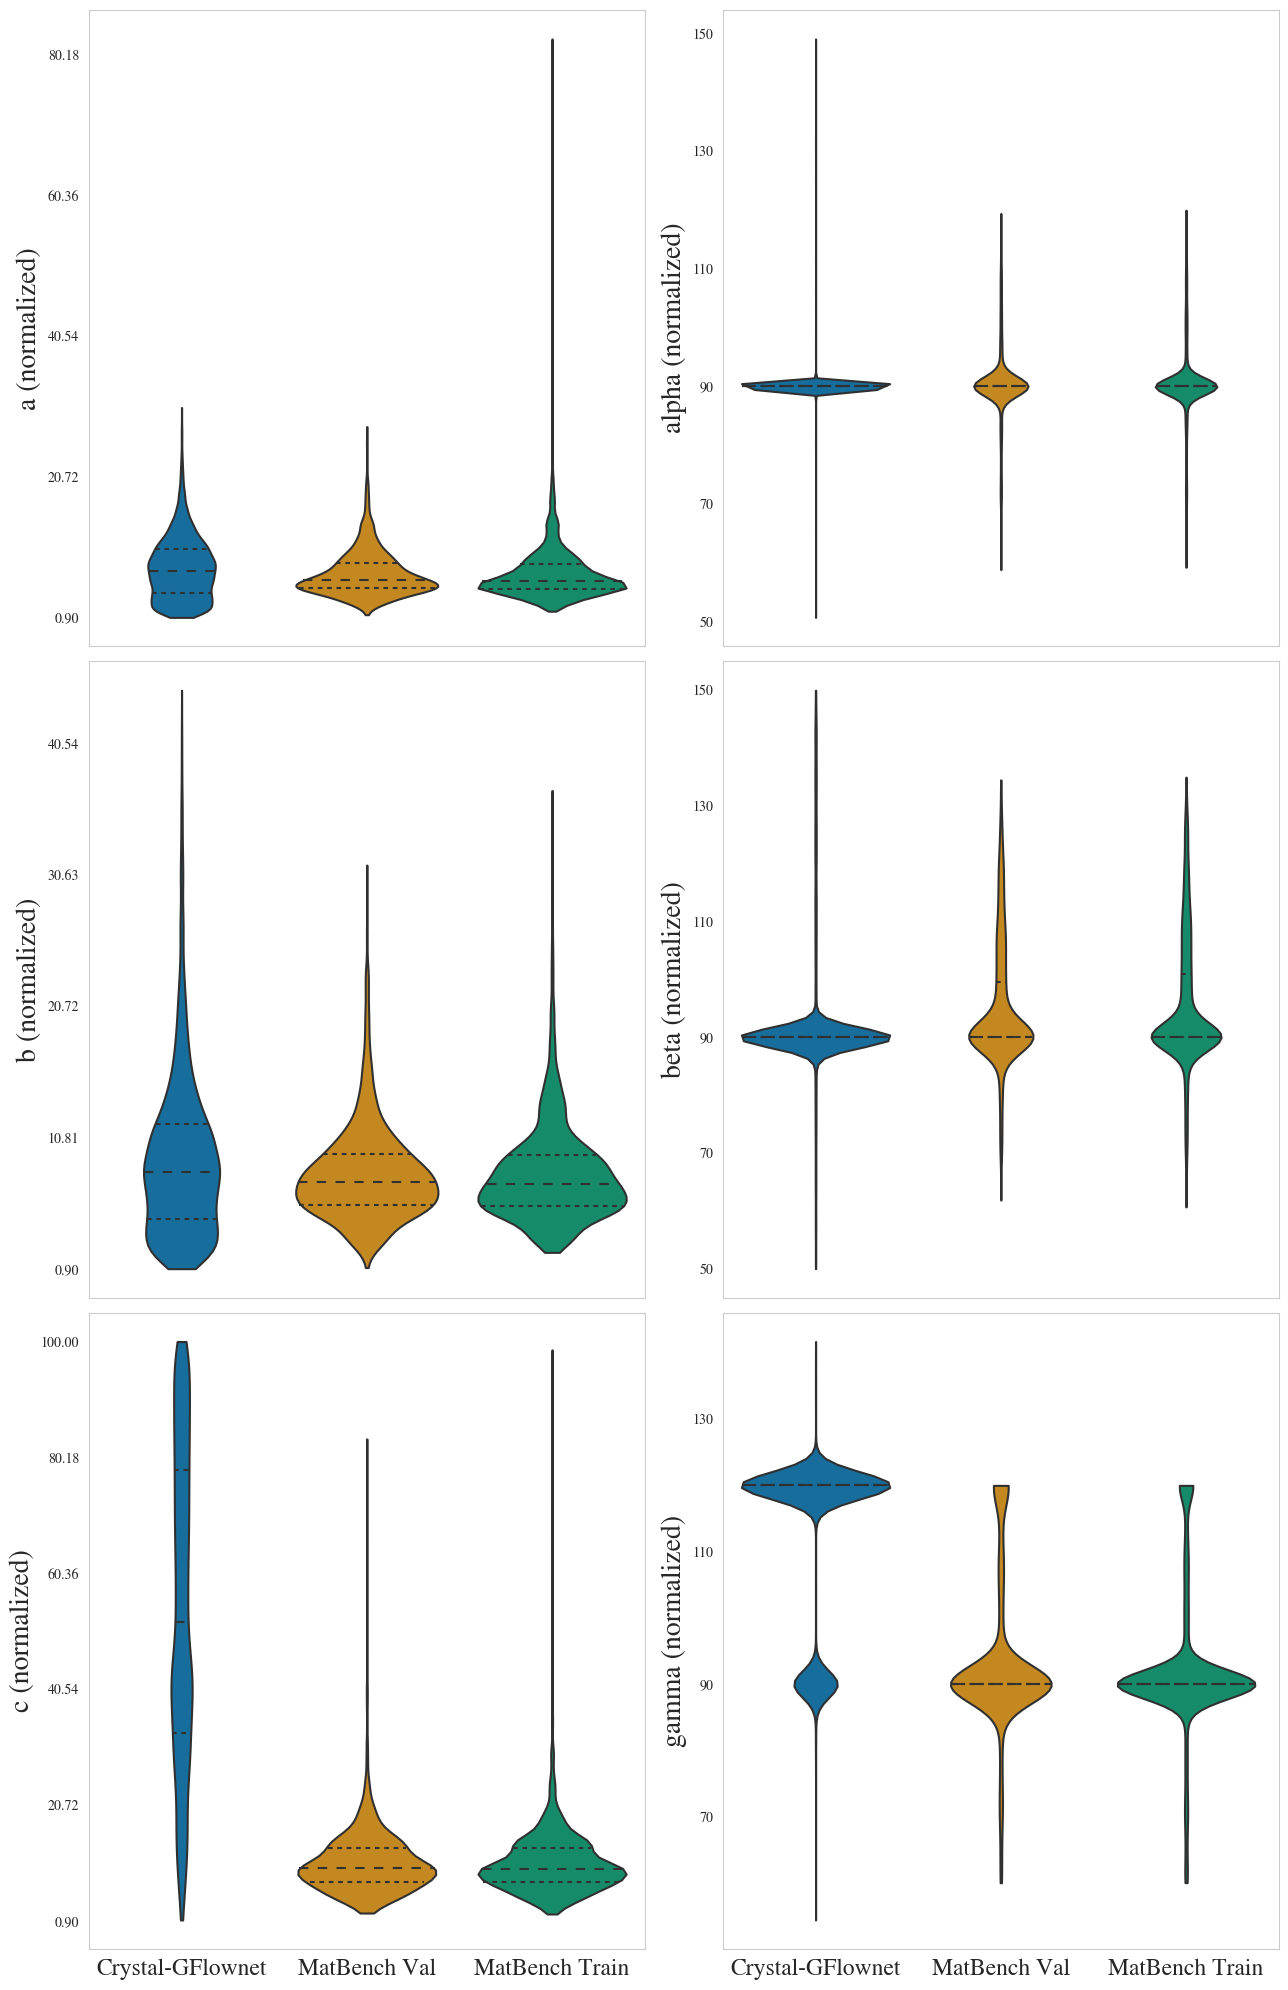

In [20]:
# plot the distribution of the lattice parameters
# in the data versus the samples
# each lattice parameter should be normalized by the range of the parameter
# in the training data
# the distribution should be plotted as a violin plot per lattice parameter

lattice_params = ["a", "b", "c", "alpha", "beta", "gamma"]
lattice_params_min = np.array([0.9, 0.9, 0.9, 50, 50, 50])
lattice_params_max = np.array([100, 100, 100, 150, 150, 150])

sdf_lattice_params = sdf[lattice_params]
valdf_lattice_params = valdf[lattice_params]
traindf_lattice_params = traindf[lattice_params]

sdf_lattice_params_normed = (sdf_lattice_params - lattice_params_min) / (
    lattice_params_max - lattice_params_min
)
valdf_lattice_params_normed = (valdf_lattice_params - lattice_params_min) / (
    lattice_params_max - lattice_params_min
)
traindf_lattice_params_normed = (traindf_lattice_params - lattice_params_min) / (
    lattice_params_max - lattice_params_min
)

lattice_params_normed = pd.concat(
    [
        sdf_lattice_params_normed,
        valdf_lattice_params_normed,
        traindf_lattice_params_normed,
    ]
)
lattice_params_normed.columns = [
    f"{c} (normalized)" for c in lattice_params_normed.columns
]
lattice_params_normed["source"] = sum(
    [
        [s] * c
        for s, c in zip(
            ["Crystal-GFlownet", "MatBench Val", "MatBench Train"],
            [len(sdf), len(valdf), len(traindf)],
        )
    ],
    [],
)

lattice_params_normed = lattice_params_normed.loc[lattice_params_normed["c (normalized)"] <= 1]

# plot the distribution of the lattice parameters as subplots:
# one subplot per lattice parameter
# one violin per data source
# the y-axis should be the normalized lattice parameter
# the x-axis should be the data source
# the x-axis should be labeled with the data source name
# the y-axis should be labeled with the lattice parameter name

fig, axes = plt.subplots(3, 2, figsize=(13, 20), sharey=False, sharex=True)

for i, p in enumerate(lattice_params):
    ax_i = [0, 2, 4, 1, 3, 5][i]
    ax = axes.flatten()[ax_i]
    sns.violinplot(
        data=lattice_params_normed,
        x="source",
        y=f"{p} (normalized)",
        ax=ax,
        cut=0,
        inner="quartile",
    )
    ax.set_ylabel(f"{p} (normalized)", fontdict={"size": 20})
    ax.set_xlabel("")
    # denormalize y ticks
    yticks = ax.get_yticks()
    denorm_yticks = [f"{denorm_l(y):.2f}" for y in yticks] if i < 3 else [f"{denorm_a(y):.0f}" for y in yticks]
    ax.set_yticklabels(denorm_yticks)
    if i >= 2:
        ax.set_xticklabels(["Crystal-GFlownet", "MatBench Val", "MatBench Train"], fontdict={"size": 17})
    ax.grid(False)
fig.tight_layout()
fig.savefig(output_path / "lattice_params.pdf")

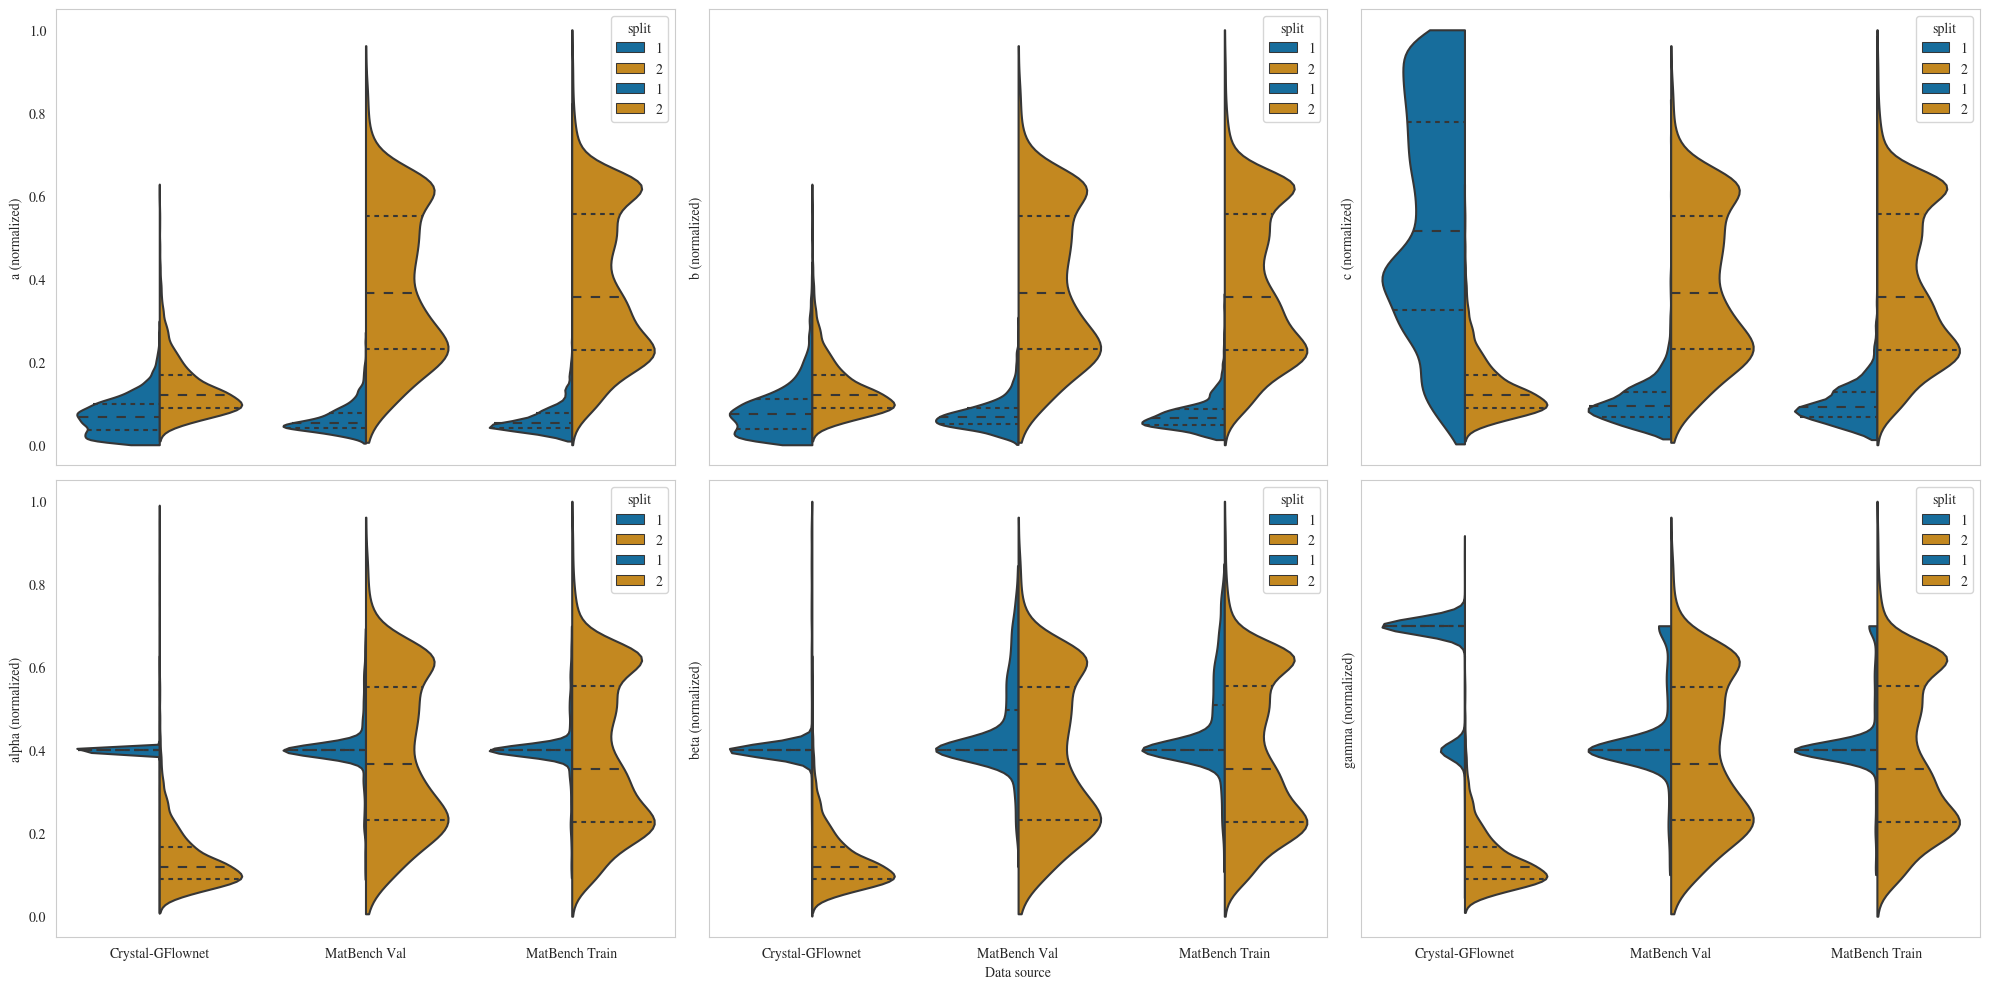

In [21]:
# plot the distribution of the lattice parameters
# in the data versus the samples
# each lattice parameter should be normalized by the range of the parameter
# in the training data
# the distribution should be plotted as a violin plot per lattice parameter

lattice_params = ["a", "b", "c", "alpha", "beta", "gamma"]
mins = np.array([0.9, 0.9, 0.9, 50, 50, 50])
maxs = np.array([100, 100, 100, 150, 150, 150])

sdf_lattice_params = sdf[lattice_params + ["energy"]]
valdf_lattice_params = valdf[lattice_params + ["energy"]]
traindf_lattice_params = traindf[lattice_params + ["energy"]]

lattice_params_df = pd.concat(
    [
        sdf_lattice_params,
        valdf_lattice_params,
        traindf_lattice_params,
    ]
)
mins = np.concatenate([mins, [lattice_params_df["energy"].min()]])
maxs = np.concatenate([maxs, [lattice_params_df["energy"].max()]])

lattice_params_df_normed = (lattice_params_df - mins) / (
    maxs - mins
)

lattice_params_df_normed.columns = [
    f"{c} (normalized)" for c in lattice_params_df_normed.columns
]
lattice_params_df_normed["source"] = sum(
    [
        [s] * c
        for s, c in zip(
            ["Crystal-GFlownet", "MatBench Val", "MatBench Train"],
            [len(sdf), len(valdf), len(traindf)],
        )
    ],
    [],
)

lattice_params_df_normed = lattice_params_df_normed.loc[lattice_params_df_normed["c (normalized)"] <= 1]
energy_normed = lattice_params_df_normed.copy()
lattice_params_df_normed["split"] = 1
dummy = lattice_params_df_normed.copy()
dummy[lattice_params_df_normed.columns] = np.nan
dummy["split"] = 2
lattice_params_df_normed = pd.concat([lattice_params_df_normed, dummy])

energy_normed["split"] = 2
dummy = energy_normed.copy()
dummy[energy_normed.columns] = np.nan
dummy["split"] = 1
energy_normed = pd.concat([energy_normed, dummy])


# plot the distribution of the lattice parameters as subplots:
# one subplot per lattice parameter
# one violin per data source
# the y-axis should be the normalized lattice parameter
# the x-axis should be the data source
# the x-axis should be labeled with the data source name
# the y-axis should be labeled with the lattice parameter name

fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharey=True, sharex=True)

for i, p in enumerate(lattice_params):
    ax = axes.flatten()[i]
    sns.violinplot(
        data=lattice_params_df_normed,
        x="source",
        y=f"{p} (normalized)",
        ax=ax,
        cut=0,
        inner="quartile",
        split=True,
        hue="split"
    )
    sns.violinplot(
        data=energy_normed,
        x="source",
        y=f"energy (normalized)",
        ax=ax,
        cut=0,
        inner="quartile",
        split=True,
        hue="split"
    )
    ax.set_ylabel(f"{p} (normalized)")
    ax.set_xlabel("")
    if i >= 3:
        if i == 4:
            ax.set_xlabel("Data source")
        ax.set_xticklabels(["Crystal-GFlownet", "MatBench Val", "MatBench Train"])
    ax.grid(False)
fig.tight_layout()
fig.savefig(output_path / "lattice_params_split.pdf")

In [22]:
sns.color_palette("colorblind", 4)[3]

(0.8352941176470589, 0.3686274509803922, 0.0)